In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary, extract_last_K_step_avg_summary
from posthoc_analysis_utils import sweep_collect_eval_data, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_indiv_rule_dynam, extract_and_convert, visualize_train_heldout_rule, extract_rule_list_from_eval_col
from circuit_toolkit.plot_utils import saveallforms
from stats_plot_utils import estimate_CI

### Paths

In [3]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SiTfigdir = join(figroot, "SiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
synopsisdir = join(figroot, "Figure_model_synopsis")

In [4]:
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [6]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists


## GPT2

### Synopsis across training runs

In [5]:
def extract_all_runs_update(root_logdir, runs_to_update=None):
    run_dataframes = {}
    for root, dirs, files in os.walk(root_logdir):
        for subdir in sorted(dirs):
            run_path = os.path.join(root, subdir)
            if os.path.isdir(run_path):
                relative_path = os.path.relpath(run_path, root_logdir)
                if runs_to_update is not None and relative_path not in runs_to_update:
                    continue
                df = extract_tensorboard_data_from_run(run_path)
                if not df.empty:
                    run_dataframes[relative_path] = df
                    print(f"Extracted data from {relative_path}")
    return run_dataframes


In [6]:
GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
tb_data_col = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

In [7]:
newruns = [k for k in list(tb_data_col.keys()) if "241122" in k]
print(len(newruns), "new runs to add\n", newruns)
tb_data_col_new = extract_all_runs_update(GPT_exproot, runs_to_update=newruns)

3 new runs to add
 ['GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241122-165627/tensorboard_logs', 'GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream16M-20241122-165705/tensorboard_logs', 'GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream1_6M-20241122-165756/tensorboard_logs']
Extracted data from GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241122-165627/tensorboard_logs
Extracted data from GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream16M-20241122-165705/tensorboard_logs
Extracted data from GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream1_6M-20241122-165756/tensorboard_logs


In [8]:
tb_data_col.update(tb_data_col_new)

In [9]:
# key = "GPT2_medium_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241122-165627/tensorboard_logs"
# check if the dataframes are the same
for k in newruns:
    if not tb_data_col[k].equals(tb_data_col_new[k]):
        print("Dataframe not the same for", k)

In [10]:
tb_data_col.update(tb_data_col_new)
pkl.dump(tb_data_col, open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "wb"))

In [11]:
if False: # first time extract all runs
    GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
    tb_data_col = extract_all_runs(GPT_exproot)
    pkl.dump(tb_data_col, open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "wb"))

Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240819-010648/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240704-041344/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240819-011524/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_cond_all-20240702-032839/tensorboard_logs
Extracted data from GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0-20240630-023945/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240818-013524/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_all_stream16M-20240704-025623/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240819-010648/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0_stream0_16M

In [11]:
tb_data_col = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

In [12]:
def simplify_runname(run_name):
    return run_name.replace("/tensorboard_logs", "").split("-2024")[0].replace("_RAVEN", "")

excluded_runs = [
    ] # 873100

syndf_GPT = extract_last_step_summary(tb_data_col, simplify_runname, exclude_runs=excluded_runs)
syndf_GPT

tag,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,full_name,step,step/epoch
run_name,,,,,,,,,,,,,
GPT2_small_joint_lm_sep_emb_uncond_heldout0_stream0_16M,1.307371,1.565116,0.891833,0.627167,3.388067,0.4400,0.127500,0.5600,0.421000,0.000000,GPT2_small_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200321/tensorboard_logs,1000000,999999
GPT2_medium_uncond_heldout0_stream16M,3.238008,3.205984,0.957333,0.324333,3.307848,0.2100,0.147000,0.7900,0.035000,0.000000,GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs,1000000,999999
GPT2_small_joint_lm_sep_emb_uncond_heldout0_stream16M,2.150116,2.144357,0.954500,0.987167,2.143040,0.2405,0.040000,0.7595,0.961500,0.000000,GPT2_small_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream16M-20241121-140316/tensorboard_logs,1000000,999999
GPT2_medium_uncond_heldout0_stream1_6M,3.191897,NaN,0.940667,0.377500,3.319388,0.2560,0.153000,0.7440,0.055000,0.000074,GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240819-010648/tensorboard_logs,262499,259999
GPT2_medium_uncond_heldout0_stream16M,3.196153,3.244510,0.962333,0.375000,3.288064,0.2110,0.138500,0.7890,0.040500,0.000000,GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240704-041344/tensorboard_logs,250000,249999
GPT2_small_joint_lm_sep_emb_uncond_heldout0_stream0_016M,0.119473,0.173264,0.847167,0.995333,11.447136,0.8810,0.002000,0.1190,0.991000,0.000000,GPT2_small_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241121-140338/tensorboard_logs,1000000,999999
GPT2_medium_uncond_heldout0_stream0_16M,0.507333,NaN,0.905000,0.504000,12.355254,0.3815,0.185000,0.6185,0.180000,0.000074,GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240819-011524/tensorboard_logs,257499,254999
GPT2_medium_cond_all,0.475036,0.482606,0.960500,0.684833,13.489779,0.1380,0.326500,0.8620,0.333000,0.000000,GPT2_medium_RAVEN_cond_all-20240702-032839/tensorboard_logs,246899,99
GPT2_small_uncond_heldout0_stream16M,3.244263,3.223624,0.950833,0.359000,3.317656,0.2270,0.177000,0.7730,0.038000,0.000000,GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs,1000000,999999


In [13]:
syndf_GPT.to_csv(join(tabdir, "GPT2_raven_tensorboard_data.csv"))

In [14]:
excluded_runs = [
    ] # 873100

syndf_GPT_std = extract_last_K_step_avg_summary(tb_data_col, simplify_runname, exclude_runs=excluded_runs, K=10, compute_std=True)
syndf_GPT_std = syndf_GPT_std.sort_index()
syndf_GPT_std.to_csv(join(tabdir, "GPT_raven_tensorboard_data_last10.csv"))
syndf_GPT_std

,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,...,Loss/train_std,Train/Avg_Loss_std,Val/AnyValid_std,Val/AnyValid_abinit_std,Val/Avg_Loss_std,Val/C2_std,Val/C2_abinit_std,Val/C3_std,Val/C3_abinit_std,lr_std
run_name,,,,,,,,,,,,,,,,,,,,,
GPT2CmbEmb_base_uncond_heldout0,1.506485,1.574005,0.911833,0.439990,9.192906,0.37500,0.136963,0.62500,0.133301,3.361111e-08,...,0.044245,0.017551,0.001703,0.007186,0.125924,0.004570,0.006078,0.004570,0.007053,2.641838e-08
GPT2_base_cond_heldout0,1.243322,1.281612,0.934583,0.593283,9.513286,0.23610,0.275900,0.76390,0.259150,3.361111e-08,...,0.043741,0.018739,0.001647,0.004758,0.129281,0.004452,0.007298,0.004452,0.009580,2.641838e-08
GPT2_base_joint_lm_cmb_emb_uncond_heldout0_stream0_16M,0.233769,0.560265,0.887250,0.888533,7.806574,0.48100,0.070750,0.51900,0.796300,1.037704e-07,...,0.004843,NaN,0.000806,0.004818,0.002669,0.002055,0.005959,0.002055,0.009638,5.678257e-08
GPT2_base_joint_lm_joint_emb_uncond_heldout0_stream0_16M,0.240702,0.549686,0.863200,0.890250,7.871315,0.58395,0.082150,0.41605,0.788300,1.037704e-07,...,0.005292,NaN,0.000816,0.007951,0.004102,0.001921,0.004559,0.001921,0.011919,5.678257e-08
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_016M,0.118319,0.141607,0.841583,0.999383,11.340110,0.88460,0.000700,0.11540,0.998200,1.037704e-07,...,0.000243,NaN,0.000934,0.000223,0.002730,0.001125,0.000537,0.001125,0.000789,5.678257e-08
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_16M,0.227812,0.534217,0.884767,0.902683,7.886419,0.47180,0.059300,0.52820,0.830350,1.037704e-07,...,0.003353,NaN,0.000861,0.005182,0.003393,0.001798,0.005303,0.001798,0.008097,5.678257e-08
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream16M,2.104376,2.136932,0.973433,0.988983,2.153408,0.17525,0.030350,0.82475,0.966150,1.037704e-07,...,0.105052,NaN,0.001037,0.001129,0.000391,0.004198,0.003448,0.004198,0.003056,5.678257e-08
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream1_6M,1.952108,2.080739,0.988933,0.984617,2.320068,0.12500,0.050200,0.87500,0.946300,1.037704e-07,...,0.081979,NaN,0.000316,0.001869,0.001059,0.000624,0.007517,0.000624,0.007189,5.678257e-08
GPT2_base_uncond_heldout0,1.405227,1.462881,0.909950,0.471191,9.299380,0.37305,0.146777,0.62695,0.172363,3.361111e-08,...,0.097962,0.018374,0.001262,0.009278,0.124833,0.004349,0.007032,0.004349,0.004207,2.641838e-08


### General Scaling curves

In [15]:
syndf_GPT = pd.read_csv(join(tabdir, "GPT_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

In [16]:
syndf_GPT["joint_readout"] = syndf_GPT.index.map(lambda x: "joint_lm" in x)
syndf_GPT["embed_type"] = syndf_GPT.index.map(lambda x: "sep" if "sep_emb" in x else "joint" if "joint_emb" in x else "cmb" if "cmb_emb" in x else "default")
syndf_GPT["heldout"] = syndf_GPT.index.map(lambda x: "_heldout0" in x)
syndf_GPT["scale"] = syndf_GPT.index.map(lambda x: "GPT2-M" if "GPT2_medium" in x else "GPT2-B" if "GPT2_base" in x else "GPT2-S" if "GPT2_small" in x else None)
syndf_GPT["dataset_size"] = syndf_GPT.index.map(extract_and_convert)
syndf_GPT["uncond"] = syndf_GPT.index.map(lambda x: "uncond" in x)
syndf_GPT["Val/C23"] = syndf_GPT["Val/C2"] + syndf_GPT["Val/C3"]
syndf_GPT["Val/C23_abinit"] = syndf_GPT["Val/C2_abinit"] + syndf_GPT["Val/C3_abinit"]
joint_str = {True: "joint_lm", False: "sep_lm"}
syndf_GPT["readout_embed"] = syndf_GPT.apply(lambda row: 
    row.embed_type + "_emb-" + joint_str[row.joint_readout] if row.embed_type != "default" \
        else "sep_emb-" + joint_str[row.joint_readout], axis=1)
# syndf_GPT["Rules/c23_cnt"] = syndf_GPT["Rules/c2_cnt"] + syndf_GPT["Rules/c3_cnt"]
syndf_GPT_sorted = syndf_GPT.sort_values(by=["uncond", "heldout", "dataset_size", "scale", "embed_type"], ascending=[False, False, False, True, False])

In [17]:
syndf_GPT.to_csv(join(tabdir, "GPT_raven_tensorboard_data_last10_annotated.csv"), )

### Joint Embedding 

In [18]:
syndf_GPT_sorted.columns

Index(['Loss/train', 'Train/Avg_Loss', 'Val/AnyValid', 'Val/AnyValid_abinit',
       'Val/Avg_Loss', 'Val/C2', 'Val/C2_abinit', 'Val/C3', 'Val/C3_abinit',
       'lr', 'full_name', 'step', 'step/epoch', 'Loss/train_std',
       'Train/Avg_Loss_std', 'Val/AnyValid_std', 'Val/AnyValid_abinit_std',
       'Val/Avg_Loss_std', 'Val/C2_std', 'Val/C2_abinit_std', 'Val/C3_std',
       'Val/C3_abinit_std', 'lr_std', 'joint_readout', 'embed_type', 'heldout',
       'scale', 'dataset_size', 'uncond', 'Val/C23', 'Val/C23_abinit',
       'readout_embed'],
      dtype='object')

In [19]:
# apply function to each row 
joint_str = {True: "joint_lm", False: "sep_lm"}
syndf_GPT_sorted["readout_embed"] = syndf_GPT_sorted.apply(lambda row: 
    row.embed_type + "_emb-" + joint_str[row.joint_readout] if row.embed_type != "default" \
        else "sep_emb-" + joint_str[row.joint_readout], axis=1)
syndf_GPT_sorted.readout_embed.unique()

array(['sep_emb-joint_lm', 'sep_emb-sep_lm', 'joint_emb-joint_lm',
       'cmb_emb-joint_lm'], dtype=object)

In [23]:
column = ['joint_readout', 'embed_type', 'heldout', 'scale',
       'dataset_size', 'uncond', 'Loss/train', 'Train/Avg_Loss', 'Val/AnyValid', 'Val/AnyValid_abinit',
       'Val/Avg_Loss', 'Val/C23', 'Val/C23_abinit', 'Val/C3', 'Val/C3_abinit',
       'step', 'step/epoch', ] # 'lr', 
# exclude columns with std in it 
syndf_GPT_sorted.query("step > 880000 and joint_readout == True").\
    loc[:, column] 

,joint_readout,embed_type,heldout,scale,dataset_size,uncond,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C23,Val/C23_abinit,Val/C3,Val/C3_abinit,step,step/epoch
run_name,,,,,,,,,,,,,,,,,
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream16M,True,sep,True,GPT2-B,16.000,True,2.104376,2.136932,0.973433,0.988983,2.153408,1.0,0.99650,0.82475,0.96615,1000000,977499
GPT2_medium_joint_lm_sep_emb_uncond_heldout0_stream16M,True,sep,True,GPT2-M,16.000,True,2.138136,2.131639,0.985500,0.991233,2.139818,1.0,0.99525,0.87550,0.98010,1000000,977499
GPT2_small_joint_lm_sep_emb_uncond_heldout0_stream16M,True,sep,True,GPT2-S,16.000,True,2.111509,2.144357,0.954550,0.988117,2.143009,1.0,1.00230,0.75955,0.96305,1000000,977499
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream1_6M,True,sep,True,GPT2-B,1.600,True,1.952108,2.080739,0.988933,0.984617,2.320068,1.0,0.99650,0.87500,0.94630,1000000,977499
GPT2_medium_joint_lm_sep_emb_uncond_heldout0_stream1_6M,True,sep,True,GPT2-M,1.600,True,1.745432,1.970312,0.984867,0.988617,2.597469,1.0,0.99640,0.87590,0.96610,1000000,977499
GPT2_small_joint_lm_sep_emb_uncond_heldout0_stream1_6M,True,sep,True,GPT2-S,1.600,True,2.109375,2.134085,0.956883,0.985100,2.178276,1.0,0.99985,0.79985,0.95270,1000000,977499
GPT2_base_joint_lm_sep_emb_uncond_heldout0_stream0_16M,True,sep,True,GPT2-B,0.160,True,0.227812,0.534217,0.884767,0.902683,7.886419,1.0,0.88965,0.52820,0.83035,1000000,977499
GPT2_base_joint_lm_joint_emb_uncond_heldout0_stream0_16M,True,joint,True,GPT2-B,0.160,True,0.240702,0.549686,0.863200,0.890250,7.871315,1.0,0.87045,0.41605,0.78830,1000000,977499
GPT2_base_joint_lm_cmb_emb_uncond_heldout0_stream0_16M,True,cmb,True,GPT2-B,0.160,True,0.233769,0.560265,0.887250,0.888533,7.806574,1.0,0.86705,0.51900,0.79630,1000000,977499


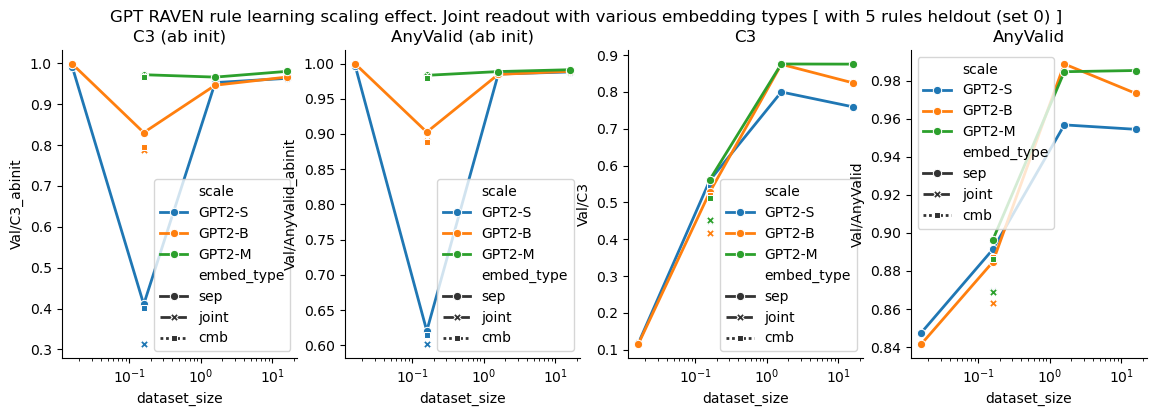

In [24]:
syndf_GPT_sorted.query("step > 990000 and joint_readout == True").\
    loc[:, column]

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.lineplot(data=syndf_GPT_sorted.query("step > 990000 and joint_readout == True"), x="dataset_size", 
                 y=metric, hue="scale", style="embed_type", 
                 hue_order=["GPT2-S", "GPT2-B", "GPT2-M"], 
                 markers=True, marker='o', ax=ax, lw=2)
    ax.set_xscale('log')
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout", fig)
plt.show()

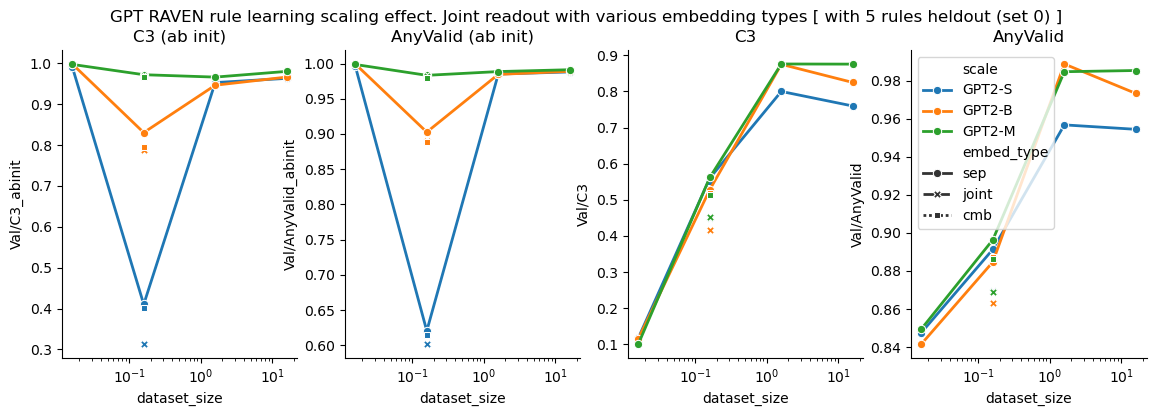

In [31]:
plot_df =  syndf_GPT_sorted.query("step > 880000 and joint_readout == True")

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.lineplot(data=plot_df, x="dataset_size", 
                 y=metric, hue="scale", style="embed_type", 
                 hue_order=["GPT2-S", "GPT2-B", "GPT2-M"], 
                 markers=True, marker='o', ax=ax, lw=2)
    ax.set_xscale('log')
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
    if ax != axs[0,3]:
        # remove legend
        ax.legend_.remove()
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout_GPTMpart", fig)
plt.show()

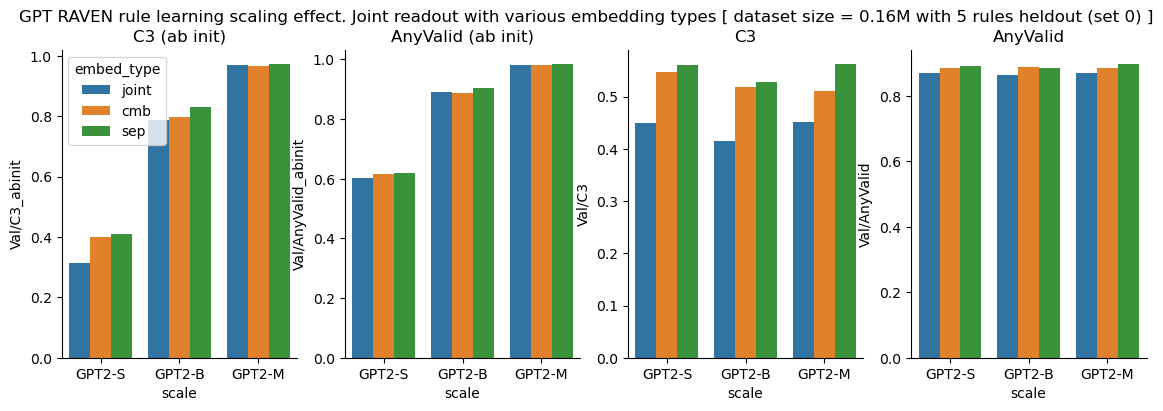

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.barplot(data=syndf_GPT_sorted.query("step > 990000 and joint_readout == True and heldout == True and dataset_size == 0.16"),  
                x="scale", hue="embed_type", y=metric, ax=ax, lw=2, hue_order=["joint", "cmb", "sep"], order=["GPT2-S", "GPT2-B", "GPT2-M"]) # 
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
    if ax != axs[0,0]:
        # close legend
        ax.legend_.remove()
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ dataset size = 0.16M with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout_barplot", fig)
plt.show()

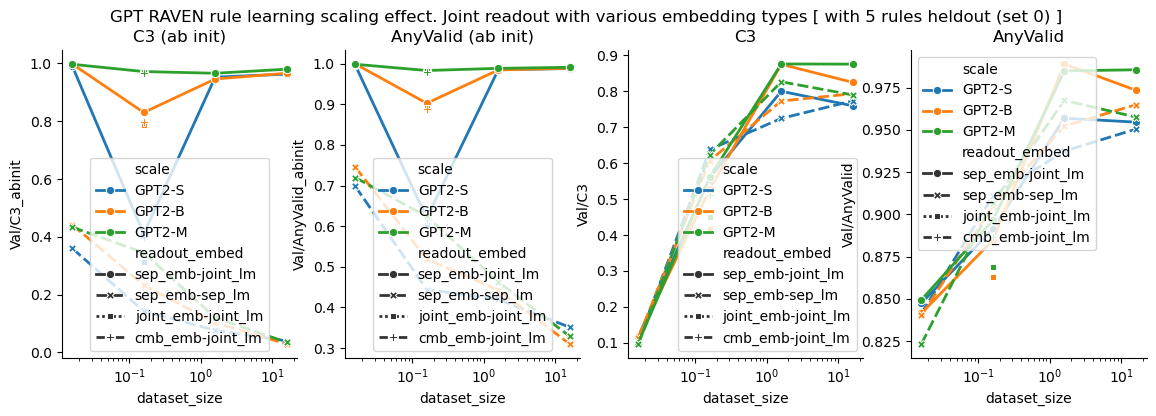

In [28]:
plot_df = syndf_GPT_sorted.query("step > 880000") #  and joint_readout == True

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.lineplot(data=plot_df, x="dataset_size",  # and joint_readout == True
                 y=metric, hue="scale", style="readout_embed", 
                 hue_order=["GPT2-S", "GPT2-B", "GPT2-M"], 
                 markers=True, marker='o', ax=ax, lw=2)
    ax.set_xscale('log')
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout_with_prev", fig)
plt.show()

In [33]:
plot_df.readout_embed.unique()

array(['sep_emb-joint_lm', 'sep_emb-sep_lm', 'joint_emb-joint_lm',
       'cmb_emb-joint_lm'], dtype=object)

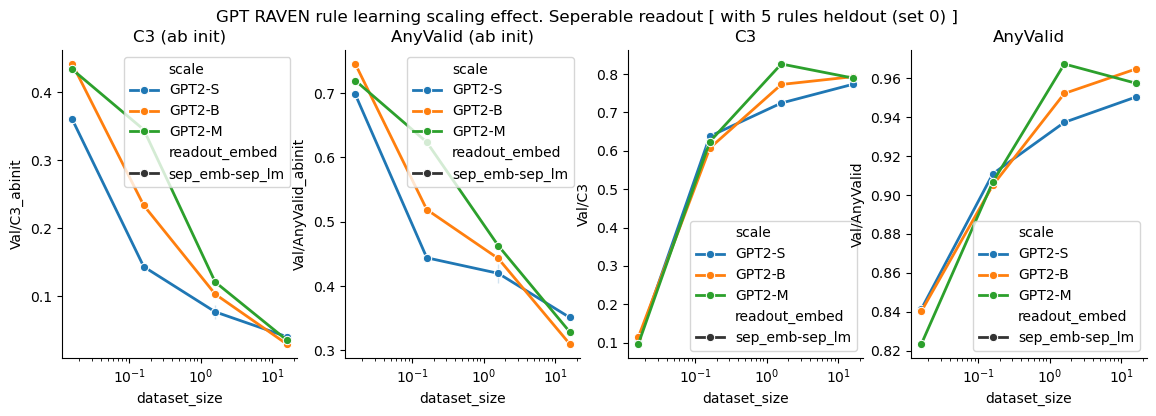

In [35]:
plot_df = syndf_GPT_sorted.query("step > 880000") #  and joint_readout == True

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.lineplot(data=plot_df, x="dataset_size",  # and joint_readout == True
                 y=metric, hue="scale", style="readout_embed", style_order=['sep_emb-sep_lm'],
                 hue_order=["GPT2-S", "GPT2-B", "GPT2-M"], 
                 markers=True, marker='o', ax=ax, lw=2)
    ax.set_xscale('log')
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
plt.suptitle("GPT RAVEN rule learning scaling effect. Seperable readout [ with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_sep_readout", fig)
plt.show()

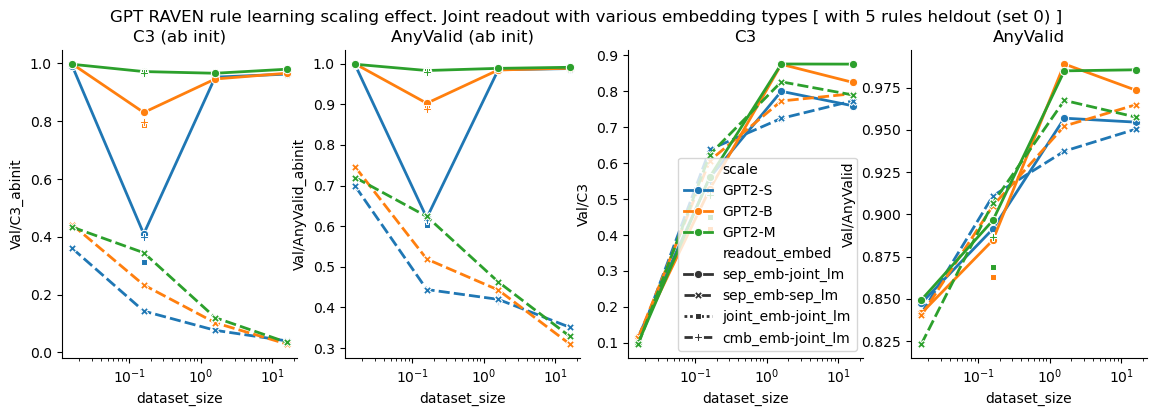

In [37]:
plot_df = syndf_GPT_sorted.query("step > 880000") #  and joint_readout == True

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.lineplot(data=plot_df, x="dataset_size",  # and joint_readout == True
                 y=metric, hue="scale", style="readout_embed", 
                 hue_order=["GPT2-S", "GPT2-B", "GPT2-M"], 
                 markers=True, marker='o', ax=ax, lw=2)
    ax.set_xscale('log')
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
    if ax != axs[0,2]:
        # remove legend
        ax.legend_.remove()
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout_with_prev_GPT2Mpart", fig)
plt.show()

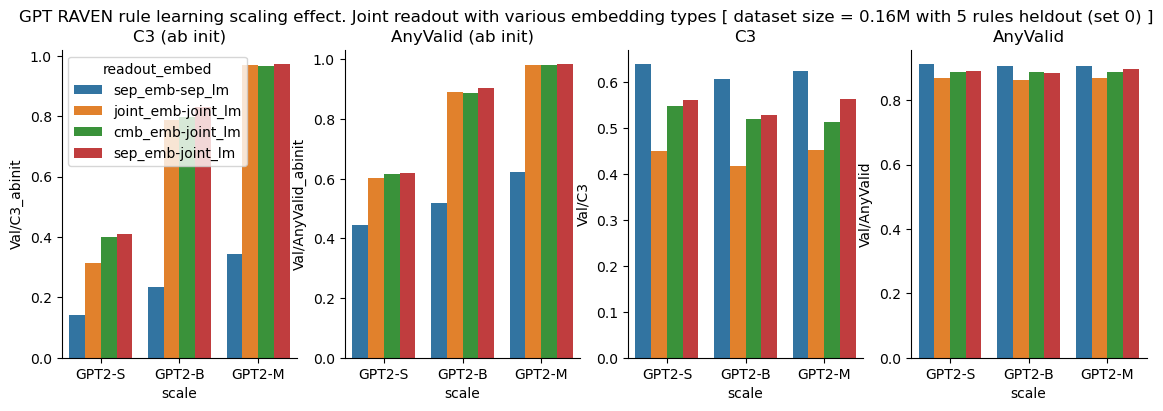

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/C3_abinit", "Val/AnyValid_abinit", "Val/C3", "Val/AnyValid"]):
    sns.barplot(data=syndf_GPT_sorted.query("step > 990000 and  heldout == True and dataset_size == 0.16"),   # joint_readout == True and
                x="scale", hue="readout_embed", y=metric, ax=ax, lw=2, hue_order=['sep_emb-sep_lm', 'joint_emb-joint_lm', 'cmb_emb-joint_lm', 'sep_emb-joint_lm',], order=["GPT2-S", "GPT2-B", "GPT2-M"]) # 
    ax.set_title(metric.replace("_abinit", " (ab init)").replace("Val/",""))
    if ax != axs[0,0]:
        # close legend
        ax.legend_.remove()
plt.suptitle("GPT RAVEN rule learning scaling effect. Joint readout with various embedding types [ dataset size = 0.16M with 5 rules heldout (set 0) ]")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_joint_readout_barplot_with_prev", fig)
plt.show()

In [21]:
syndf_GPT.query("step > 900000 and joint_readout == True").full_name.tolist()

['GPT2_base_joint_lm_cmb_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200425/tensorboard_logs',
 'GPT2_base_joint_lm_joint_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200329/tensorboard_logs',
 'GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241121-002559/tensorboard_logs',
 'GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200339/tensorboard_logs',
 'GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream16M-20241121-002522/tensorboard_logs',
 'GPT2_base_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream1_6M-20241121-002546/tensorboard_logs',
 'GPT2_small_joint_lm_cmb_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200229/tensorboard_logs',
 'GPT2_small_joint_lm_joint_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200253/tensorboard_logs',
 'GPT2_small_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_016M-20241121-140338/tensorboard_logs',
 'GPT2_small_joint_lm_sep_emb_RAVEN_uncond_heldout0_stream0_16M-20241120-200321/tensorboard_logs',
 'GPT2_small_

### Previous non-joint readout 

In [11]:
syndf_GPT_sorted.query("step > 990000")

,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,...,Val/C2_abinit_std,Val/C3_std,Val/C3_abinit_std,lr_std,heldout,scale,dataset_size,uncond,Val/C23,Val/C23_abinit
run_name,,,,,,,,,,,,,,,,,,,,,
GPT2_base_uncond_heldout0_stream16M,3.214220,3.211074,0.964833,0.309950,3.338735,0.20685,0.14645,0.79315,0.02935,1.037704e-07,...,0.007104,0.002517,0.002878,5.678257e-08,True,GPT2-B,16.000,True,1.0,0.17580
GPT2_medium_uncond_heldout0_stream16M,3.180018,3.205984,0.957533,0.328717,3.307523,0.21025,0.14750,0.78975,0.03520,1.037704e-07,...,0.009292,0.002045,0.005073,5.678257e-08,True,GPT2-M,16.000,True,1.0,0.18270
GPT2_small_uncond_heldout0_stream16M,3.210385,3.223624,0.950417,0.351150,3.317277,0.22670,0.17170,0.77330,0.04010,1.037704e-07,...,0.010881,0.002188,0.004254,5.678257e-08,True,GPT2-S,16.000,True,1.0,0.21180
GPT2_base_uncond_heldout0_stream1_6M,2.934804,3.115486,0.952250,0.442917,3.751266,0.22710,0.22885,0.77290,0.10275,1.037704e-07,...,0.005788,0.002885,0.008139,5.678257e-08,True,GPT2-B,1.600,True,1.0,0.33160
GPT2_medium_uncond_heldout0_stream1_6M,2.600170,2.964224,0.967417,0.462850,4.656226,0.17370,0.25820,0.82630,0.12055,1.037704e-07,...,0.009455,0.003529,0.006841,5.678257e-08,True,GPT2-M,1.600,True,1.0,0.37875
GPT2_small_uncond_heldout0_stream1_6M,3.023333,3.123017,0.937683,0.434383,3.575562,0.26680,0.21685,0.73320,0.08730,1.037704e-07,...,0.008273,0.003743,0.005959,5.678257e-08,True,GPT2-S,1.600,True,1.0,0.30415
GPT2_small_uncond_heldout0_stream1_6M,3.101946,3.207781,0.937100,0.405267,3.377559,0.28420,0.20120,0.71580,0.06600,1.037704e-07,...,0.008954,0.002679,0.005207,5.678257e-08,True,GPT2-S,1.600,True,1.0,0.26720
GPT2_base_uncond_heldout0_stream0_16M,0.436287,1.050831,0.905083,0.518983,15.796246,0.39280,0.15495,0.60720,0.23355,1.037704e-07,...,0.007755,0.002300,0.009320,5.678257e-08,True,GPT2-B,0.160,True,1.0,0.38850
GPT2_medium_uncond_heldout0_stream0_16M,0.240402,0.625034,0.906750,0.623883,21.620736,0.37605,0.19090,0.62395,0.34510,1.037704e-07,...,0.006769,0.001848,0.006068,5.678257e-08,True,GPT2-M,0.160,True,1.0,0.53600


In [15]:
syndf_GPT_sorted.query("step > 990000 and heldout == True and dataset_size == 0.16").\
    loc[:, ["scale","Val/AnyValid_abinit", "Val/C3_abinit", "Val/C23_abinit", "Val/AnyValid","Val/C3", ]]

,scale,Val/AnyValid_abinit,Val/C3_abinit,Val/C23_abinit,Val/AnyValid,Val/C3
run_name,,,,,,
GPT2_base_uncond_heldout0_stream0_16M,GPT2-B,0.518983,0.23355,0.3885,0.905083,0.60720
GPT2_medium_uncond_heldout0_stream0_16M,GPT2-M,0.623883,0.34510,0.5360,0.906750,0.62395
GPT2_small_uncond_heldout0_stream0_16M,GPT2-S,0.444033,0.14320,0.2864,0.910950,0.63795


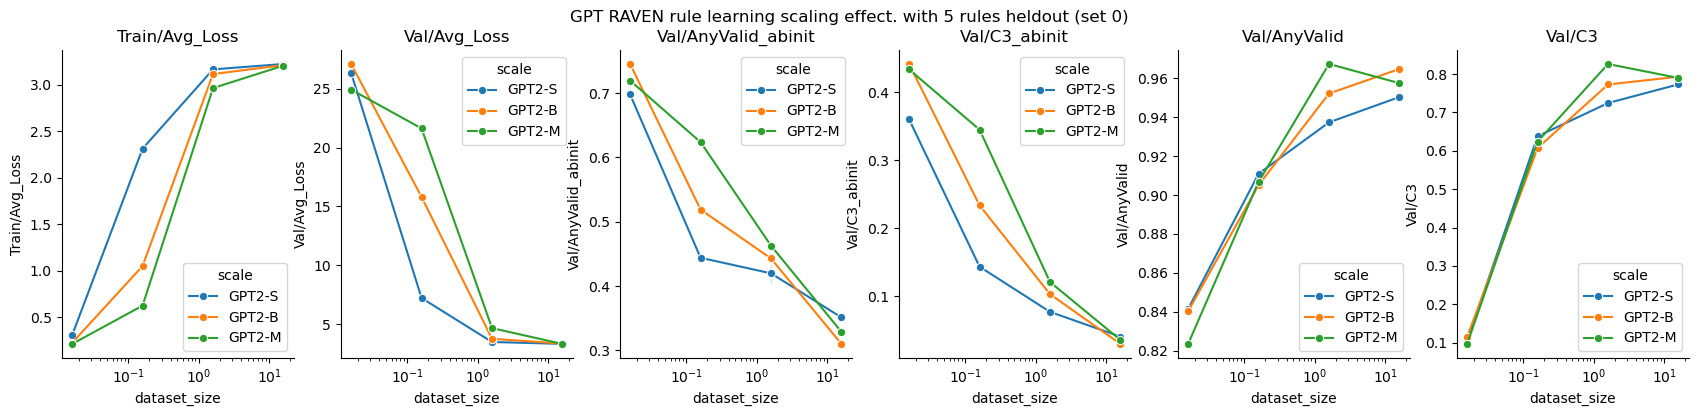

In [41]:
syndf_GPT_prune = syndf_GPT_sorted.query("step > 990000")
fig, axs = plt.subplots(1, 6, figsize=(21, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Train/Avg_Loss", "Val/Avg_Loss", "Val/AnyValid_abinit", "Val/C3_abinit", "Val/AnyValid", "Val/C3", ]):
    sns.lineplot(data=syndf_GPT_prune[syndf_GPT_prune.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["GPT2-S", "GPT2-B", "GPT2-M"])#
    ax.set_title(metric)
    ax.set_xscale('log')
# for ax, metric in zip(axs[1,:], ["Train/Avg_Loss", "Val/Avg_Loss", "Val/AnyValid", "Val/C3", "Val/AnyValid_abinit", "Val/C3_abinit",]):
#     sns.lineplot(data=syndf_GPT_prune[syndf_GPT_prune.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["GPT2-S", "GPT2-B", "GPT2-M"])
#     ax.set_title(metric)
#     ax.set_xscale('log')
plt.suptitle("GPT RAVEN rule learning scaling effect. with 5 rules heldout (set 0)")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect", fig)
plt.show()

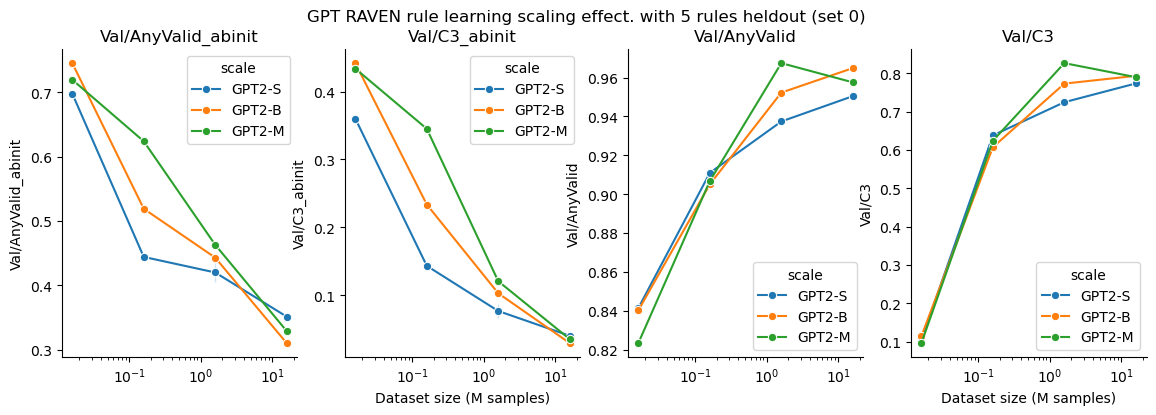

In [40]:
syndf_GPT_prune = syndf_GPT_sorted.query("step > 990000")
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Val/AnyValid_abinit", "Val/C3_abinit", "Val/AnyValid", "Val/C3", ]):
    sns.lineplot(data=syndf_GPT_prune[syndf_GPT_prune.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["GPT2-S", "GPT2-B", "GPT2-M"])#
    ax.set_title(metric)
    ax.set_xscale('log')
    if ax == axs[0,1] or ax == axs[0,3]:
        ax.set_xlabel("Dataset size (M samples)")
    else:
        ax.set_xlabel("")
# for ax, metric in zip(axs[1,:], ["Train/Avg_Loss", "Val/Avg_Loss", "Val/AnyValid", "Val/C3", "Val/AnyValid_abinit", "Val/C3_abinit",]):
#     sns.lineplot(data=syndf_GPT_prune[syndf_GPT_prune.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["GPT2-S", "GPT2-B", "GPT2-M"])
#     ax.set_title(metric)
#     ax.set_xscale('log')
plt.suptitle("GPT RAVEN rule learning scaling effect. with 5 rules heldout (set 0)")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_rule_eval", fig)
plt.show()

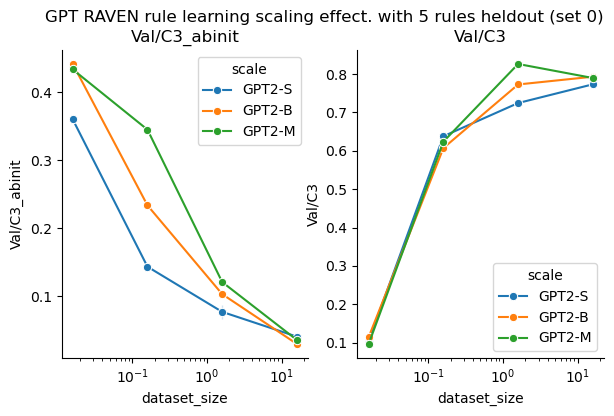

In [39]:
syndf_GPT_prune = syndf_GPT_sorted.query("step > 990000")
fig, axs = plt.subplots(1, 2, figsize=(7, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], [ "Val/C3_abinit", "Val/C3",]):
    sns.lineplot(data=syndf_GPT_prune[syndf_GPT_prune.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["GPT2-S", "GPT2-B", "GPT2-M"])#
    ax.set_title(metric)
    ax.set_xscale('log')
    
plt.suptitle("GPT RAVEN rule learning scaling effect. with 5 rules heldout (set 0)")#Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "GPT_raven_rule_learning_scaling_effect_rule_eval_C3only", fig)
plt.show()

#### Scractch

In [ ]:
syndf_GPT_sorted = syndf_GPT.sort_values(by=["uncond", "heldout", "stream16M", "scale", ], ascending=[False, False, False, True])
figh = plt.figure(figsize=(5, 6))
sns.barplot(data=syndf_GPT_sorted[syndf_GPT_sorted.heldout==True], x="run_name", y="Val/C3_abinit", hue="uncond")
# syndf_GPT.plot.bar(x="run_name", y="Val/C3_abinit", hue="heldout")
plt.xticks(rotation=-45, ha='left')
plt.show()

In [ ]:
syndf_GPT_sorted = syndf_GPT.sort_values(by=["uncond", "heldout", "stream16M", "scale", ], 
                                               ascending=[False, False, False, True])
# create a new column with shortened run names
syndf_GPT_sorted["run_label"] = syndf_GPT_sorted.index.map(lambda x: x.replace("_heldout0","").replace("GPT2",""))

figh, axs = plt.subplots(1, 5, figsize=(18, 6), sharex=True)
for ax, metric in zip(axs, ["Val/C3", "Val/AnyValid", "Val/C3_abinit", "Val/C2_abinit", "Val/AnyValid_abinit"]):
    sns.barplot(data=syndf_GPT_sorted[syndf_GPT_sorted.heldout==True], x="run_label", y=metric, 
                hue="stream16M", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    ax.set_title(metric)
plt.show()

In [ ]:
syndf_GPT_sorted = syndf_GPT.sort_values(by=["uncond", "heldout", "stream16M", "scale", ], 
                                               ascending=[False, False, False, True])
# create a new column with shortened run names
syndf_GPT_sorted["run_label"] = syndf_GPT_sorted.index.map(lambda x: x.replace("_heldout0","").replace("GPT2",""))

figh, axs = plt.subplots(1, 5, figsize=(18, 6), sharex=True)
for ax, metric in zip(axs, ["Val/C3", "Val/AnyValid", "Val/C3_abinit", "Val/C2_abinit", "Val/AnyValid_abinit"]):
    sns.barplot(data=syndf_GPT_sorted[syndf_GPT_sorted.heldout==False], 
                x="run_label", y=metric, hue="stream16M", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    ax.set_title(metric)
plt.show()

In [ ]:
syndf_GPT_sorted = syndf_GPT.sort_values(by=["uncond", "heldout", "stream16M", "scale", ], ascending=[False, False, False, True])
figh = plt.figure(figsize=(5, 6))
sns.barplot(data=syndf_GPT_sorted[syndf_GPT_sorted.heldout==False], x="run_name", y="Val/C3_abinit", hue="uncond")
# syndf_GPT.plot.bar(x="run_name", y="Val/C3_abinit", hue="heldout")
plt.xticks(rotation=-45, ha='left')
plt.show()

### General learning dynamics

In [ ]:
list(tb_data_col)

In [ ]:
for expfullname in tb_data_col:
    tb_record = tb_data_col[expfullname]
    expname = expfullname.split("/")[0]
    print(expfullname)
    # print(tb_record.keys())
    # print(tb_record['tag'].unique())    
    tb_anyvalid = tb_record[tb_record.tag=='Val/AnyValid']
    tb_anyvalid["anyvalid_renorm"] = (tb_anyvalid["value"] - 2/3) * 3
    figh = plt.figure(figsize=(6, 5))
    sns.lineplot(data=tb_anyvalid, x='step', y='anyvalid_renorm', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3'], x='step', y='value', label='C3')
    # sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid'], x='step', y='value', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid_abinit'], x='step', y='value', label='AnyValid_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3_abinit'], x='step', y='value', label='C3_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C2_abinit'], x='step', y='value', label='C2_abinit')
    plt.legend() # ['Val/C3', 'Val/C3_abinit', 'Val/C2_abinit', 'Val/AnyValid_abinit']
    plt.title(expname)
    saveallforms(GPTfigdir, f"{expname}_valid_consist_summary", figh)
    plt.show()
    # raise ValueError
    # plot 
    # plt.plot(tb_record['Val/C3'])
    # filter tag = 'heldout0'

### Individual rule learning dynamics

In [ ]:
for expfullname in tb_data_col.keys():
    print(expfullname)
    expname = expfullname.split("/tensorboard_logs")[0]
    prefix = "eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
    eval_sample_num = rule_list_all.shape[1]
    print(expname)
    if "heldout0" in expname:
        heldout_id = [1, 16, 20, 34, 37]  
    else:
        heldout_id = []

    figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                            titlestr=f"{expname}\nValid rule count separated by rule type")
    saveallforms(GPTfigdir, f"{expname}_indiv_rule_validity", figh)

    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
    saveallforms(GPTfigdir, f"{expname}_indiv_rule_consistency", figh)
    
    figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num * 3, reflevel=1 / 40,
                                titlestr=f"{expname}\nValid rule fraction")
    saveallforms(GPTfigdir, f"{expname}_train_held_rule_validity", figh)

    figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num, reflevel=1 / 40,
                                titlestr=f"{expname}\nC3 sample fraction")
    saveallforms(GPTfigdir, f"{expname}_train_held_rule_consistency", figh)

In [ ]:
expname = "GPT2_medium_RAVEN_uncond_heldout0-20240701-133418"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix="eval_epoch")

In [ ]:
expname = "GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240704-041344"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix="eval_step")

In [ ]:
expname = "GPT2_medium_RAVEN_uncond_all_stream16M-20240704-025623"
expname = "GPT2_medium_RAVEN_cond_all_stream16M-20240704-030228"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix="eval_step")

In [ ]:
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
print(expname)
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                        titlestr=f"{expname}\nValid rule count separated by rule type")
saveallforms(figdir, f"{expname}_indiv_rule_validity", figh)

figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
saveallforms(figdir, f"{expname}_indiv_rule_consistency", figh)

In [ ]:
rule_list_all.shape

In [ ]:
epoch_list, rule_list_all_cont, consistency_all_cont = extract_rule_list_from_eval_col(eval_col, is_abinit=False)

In [70]:
# compute the accuracy of each type of rules
# find the mask for each type of rule prompt 

In [81]:
epoch_num = rule_list_all_cont.shape[0]
rule_num = 40
acc_cnt_table = np.zeros((epoch_num, rule_num))
accuracy_table = np.zeros((epoch_num, rule_num))
mis_cnt_table = np.zeros((epoch_num, rule_num, rule_num))
for epochi in range(epoch_num):
    rule_list = rule_list_all_cont[epochi]
    consistency_list = consistency_all_cont[epochi]
    for rulei in range(rule_num):
        rule_mask = (rule_list[:,0]==np.array([rulei])) & (rule_list[:,1]==np.array([rulei]))
        C3_rules = consistency_list[0][rule_mask]
        C3_rules_flatten = sum(list(C3_rules), [])
        C3_cont_cnt = len(C3_rules_flatten)
        accuracy_table[epochi, rulei] = C3_cont_cnt / sum(rule_mask)
        acc_cnt_table[epochi, rulei] = C3_cont_cnt
        # raise NotImplementedError
        # for rulej in range(rule_num):
        #     mis_cnt_table[epochi, rulei, rulej] = (rule_list[rule_mask][:,:,0]==np.array([rulej])).sum()

# (rule_list_all_cont[:,:,1]==np.array([1])).sum()

In [ ]:
heldout_mask = np.zeros((40,)).astype(bool)
heldout_mask[heldout_id] = True
plt.subplots(1, 2, figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, accuracy_table[:, ~heldout_mask], alpha=0.4)
plt.plot(epoch_list, accuracy_table[:, ~heldout_mask].mean(axis=1), color='black', linewidth=2)
plt.subplot(1, 2, 2)
plt.plot(epoch_list, accuracy_table[:, heldout_mask], alpha=0.4)
plt.plot(epoch_list, accuracy_table[:, heldout_mask].mean(axis=1), color='black', linewidth=2)
plt.suptitle("Accuracy of inpainting / continuation for each rule type")
plt.show()

### Scratch space

In [ ]:
expname = "GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240704-041344"
assert os.path.exists(join(GPT_exproot, expname, "samples")), expname  
print(sorted(os.listdir(join(GPT_exproot, expname, "samples"))))
# for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
epoch_nums = sorted([int(f.split("eval_step")[-1].split(".pt")[0]) for f in os.listdir(join(GPT_exproot, expname,'samples'))])
eval_col = {}
for epoch_num in tqdm(epoch_nums):
    samples_eval = torch.load(join(GPT_exproot, expname, 'samples', f"eval_step{epoch_num}.pt"))
    eval_col[epoch_num] = samples_eval

In [ ]:
expname = "GPT2_medium_RAVEN_uncond_heldout0-20240701-133418"
assert os.path.exists(join(GPT_exproot, expname, "samples")), expname  
# for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
epoch_nums = sorted([int(f.split("eval_epoch")[-1].split(".pt")[0]) for f in os.listdir(join(GPT_exproot, expname,'samples'))])
eval_col = {}
for epoch_num in tqdm(epoch_nums):
    samples_eval = torch.load(join(GPT_exproot, expname, 'samples', f"eval_epoch{epoch_num}.pt"))
    eval_col[epoch_num] = samples_eval

In [ ]:
is_abinit = False

epoch_list = list(eval_col.keys())
rule_list_all = []
consistency_all = []
for epoch in eval_col.keys():
    if is_abinit:
        rule_list_all.append(eval_col[epoch]['rule_col_list_abinit'])
        consistency_all.append((eval_col[epoch]['C3_list_abinit'], eval_col[epoch]['C2_list_abinit']))
    else:
        rule_list_all.append(eval_col[epoch]['rule_col_list'])
        consistency_all.append((eval_col[epoch]['C3_list'], eval_col[epoch]['C2_list']))
rule_list_all = np.array(rule_list_all, dtype=object)
consistency_all = np.array(consistency_all, dtype=object)
print(rule_list_all.shape, consistency_all.shape)

In [ ]:
tb_data_col['GPT2_medium_RAVEN_cond_heldout0-20240701-231350/tensorboard_logs']

In [ ]:
tb_data_col['GPT2_medium_RAVEN_cond_heldout0-20240701-231350/tensorboard_logs']["tag"].unique()

In [ ]:
# Create an empty dataframe
result_df = []
# Iterate over the runs in tb_data_col
for run_name, run_data in tb_data_col.items():
    # Get the last step for each tag
    last_step_data = run_data.groupby('tag')['step'].max().reset_index()
    # Extract the value at the last step for each tag
    last_step_values = run_data.merge(last_step_data, on=['tag', 'step'], how='inner')
    if simplify_runname is not None:
        last_step_values["run_name"] = simplify_runname(run_name) 
    else:
        last_step_values["run_name"] = run_name
    last_step_values = last_step_values.pivot(index='run_name', columns='tag', values='value')
    # Append the extracted values to the result dataframe
    result_df.append(last_step_values)
result_df = pd.concat(result_df)

## Mamba

In [8]:
tb_data_col_SSM = extract_all_runs(SSM_exproot)

In [43]:
def simplify_runname_SSM(run_name):
    return run_name.replace("/tensorboard_logs", "").split("-2024")[0].replace("_RAVEN", "")#.replace("_new", "")

syndf_SSM = extract_last_step_summary(tb_data_col_SSM, simplify_runname_SSM, exclude_runs=())
syndf_SSM

tag,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,full_name,step,step/epoch
run_name,,,,,,,,,,,,,
Mamba_base_uncond_heldout0,3.530324,3.783875,0.863333,0.337728,3.540741,0.8945,0.024902,0.1055,0.000977,9.805957e-05,Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs,4888,0
mamba_big_uncond_heldout0,4.619632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.700000e-05,mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs,86,86
mamba_huge_uncond_all,0.227859,0.231787,0.922500,0.596680,24.653305,0.3005,0.236816,0.6995,0.225586,3.032820e-06,mamba_huge_RAVEN_uncond_all-20240730-004038/tensorboard_logs,239414,95
mamba_huge_uncond_heldout0,7.127731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-06,mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs,0,0
mamba_big_uncond_heldout0,0.254182,0.225767,0.889000,0.537272,26.397144,0.4885,0.171387,0.5115,0.174805,0.000000e+00,mamba_big_RAVEN_uncond_heldout0-20240726-153306/tensorboard_logs,216099,99
mamba_big_uncond_all,0.227219,0.231080,0.911667,0.554688,26.789389,0.3585,0.179688,0.6415,0.213379,0.000000e+00,mamba_big_RAVEN_uncond_all-20240730-003500/tensorboard_logs,246899,99
Mamba_base_uncond_heldout0,0.279168,0.276806,0.866500,0.418294,44.025986,0.6140,0.100586,0.3860,0.040527,0.000000e+00,Mamba_base_RAVEN_uncond_heldout0-20240726-004710/tensorboard_logs,216099,99
mamba_medium_uncond_all,0.233620,0.235761,0.895667,0.513509,32.534550,0.4280,0.152832,0.5720,0.125977,0.000000e+00,mamba_medium_RAVEN_uncond_all-20240729-022153/tensorboard_logs,246899,99
mamba_medium_uncond_heldout0,0.293251,0.281547,0.890000,0.487467,22.352768,0.4880,0.146484,0.5120,0.133789,3.402546e-05,mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs,142604,64


In [44]:
excluded_runs = [
    "Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs",
    "mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs",
    "mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs",
    "mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs",
]

syndf_SSM = extract_last_step_summary(tb_data_col_SSM, simplify_runname_SSM, exclude_runs=excluded_runs)
syndf_SSM

Excluding Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs
Excluding mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs
Excluding mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs
Excluding mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs


tag,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,full_name,step,step/epoch
run_name,,,,,,,,,,,,,
mamba_huge_uncond_all,0.227859,0.231787,0.922500,0.596680,24.653305,0.3005,0.236816,0.6995,0.225586,0.000003,mamba_huge_RAVEN_uncond_all-20240730-004038/tensorboard_logs,239414,95
mamba_big_uncond_heldout0,0.254182,0.225767,0.889000,0.537272,26.397144,0.4885,0.171387,0.5115,0.174805,0.000000,mamba_big_RAVEN_uncond_heldout0-20240726-153306/tensorboard_logs,216099,99
mamba_big_uncond_all,0.227219,0.231080,0.911667,0.554688,26.789389,0.3585,0.179688,0.6415,0.213379,0.000000,mamba_big_RAVEN_uncond_all-20240730-003500/tensorboard_logs,246899,99
Mamba_base_uncond_heldout0,0.279168,0.276806,0.866500,0.418294,44.025986,0.6140,0.100586,0.3860,0.040527,0.000000,Mamba_base_RAVEN_uncond_heldout0-20240726-004710/tensorboard_logs,216099,99
mamba_medium_uncond_all,0.233620,0.235761,0.895667,0.513509,32.534550,0.4280,0.152832,0.5720,0.125977,0.000000,mamba_medium_RAVEN_uncond_all-20240729-022153/tensorboard_logs,246899,99
mamba_medium_uncond_heldout0,0.249798,0.229807,0.879167,0.482910,33.249817,0.5525,0.122559,0.4475,0.110840,0.000000,mamba_medium_RAVEN_uncond_heldout0-20240726-153805/tensorboard_logs,216099,99


In [45]:
pkl.dump(tb_data_col_SSM, open(join(tabdir, "SSM_raven_tensorboard_raw_data.pkl"), "wb"))
syndf_SSM.to_csv(join(tabdir, "SSM_raven_tensorboard_data.csv"))

In [46]:
excluded_runs = [
    "Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs",
    "mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs",
    "mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs",
    "mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs",
]

syndf_SSM_std = extract_last_K_step_avg_summary(tb_data_col_SSM, simplify_runname_SSM, exclude_runs=excluded_runs, K=10, compute_std=True)
syndf_SSM_std = syndf_SSM_std.sort_index()
syndf_SSM_std.to_csv(join(tabdir, "SSM_raven_tensorboard_data_last10.csv"))
syndf_SSM_std

Excluding Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs
Excluding mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs
Excluding mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs
Excluding mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs


,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,...,Loss/train_std,Train/Avg_Loss_std,Val/AnyValid_std,Val/AnyValid_abinit_std,Val/Avg_Loss_std,Val/C2_std,Val/C2_abinit_std,Val/C3_std,Val/C3_abinit_std,lr_std
run_name,,,,,,,,,,,,,,,,,,,,,
Mamba_base_uncond_heldout0,0.278484,0.295168,0.870017,0.421940,42.948037,0.60625,0.096240,0.39375,0.040186,3.361111e-08,...,0.005144,0.014021,0.003565,0.007124,0.874274,0.007076,0.005134,0.007076,0.005229,2.641838e-08
mamba_big_uncond_all,0.232035,0.233278,0.912283,0.561263,26.014898,0.35790,0.180420,0.64210,0.221436,4.878444e-08,...,0.003726,0.001228,0.001401,0.008691,0.636215,0.006050,0.006267,0.006050,0.013072,2.750709e-08
mamba_big_uncond_heldout0,0.230091,0.228129,0.888450,0.548193,25.839142,0.48755,0.174023,0.51245,0.183496,3.361111e-08,...,0.009865,0.001350,0.001092,0.007466,0.460574,0.004038,0.007676,0.004038,0.009498,2.641838e-08
mamba_huge_uncond_all,0.234038,0.232616,0.919733,0.591195,23.445947,0.30545,0.229687,0.69455,0.231787,3.075446e-06,...,0.004397,0.000571,0.001897,0.006529,0.745868,0.003693,0.006620,0.003693,0.007697,2.973073e-08
mamba_medium_uncond_all,0.236122,0.239627,0.898400,0.506982,31.680666,0.42210,0.153906,0.57790,0.116602,4.878444e-08,...,0.006094,0.002314,0.002078,0.004257,0.682377,0.004345,0.006702,0.004345,0.006761,2.750709e-08
mamba_medium_uncond_heldout0,0.230448,0.233684,0.879700,0.484701,32.739759,0.54685,0.130127,0.45315,0.108594,3.361111e-08,...,0.008800,0.002255,0.000777,0.006852,0.403273,0.003000,0.007341,0.003000,0.004488,2.641838e-08


### Simple comparison

In [49]:
tb_data_col_SSM = pkl.load(open(join(tabdir, "SSM_raven_tensorboard_raw_data.pkl"), "rb"))
syndf_SSM = pd.read_csv(join(tabdir, "SSM_raven_tensorboard_data_last10.csv"), index_col=0)

In [ ]:
syndf_SSM

### Synopsis of models

In [ ]:
syndf_SSM["heldout"] = syndf_SSM.index.map(lambda x: "_heldout0" in x)
syndf_SSM["scale"] = syndf_SSM.index.map(lambda x: "SSMx1" if "base" in x else 
                                                   "SSMx2" if "medium" in x else 
                                                   "SSMx3" if "big" in x else 
                                                   "SSMx4" if "huge" in x else 
                                                   None)

#### Effect of SSM Scale of Rule Learning

In [ ]:
# plot the results using seaborn
fig, axs = plt.subplots(1, 6, figsize=(17.5, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ['Train/Avg_Loss', 'Val/Avg_Loss', "Val/AnyValid", "Val/C3", "Val/AnyValid_abinit", "Val/C3_abinit",]):
    sns.barplot(data=syndf_SSM[syndf_SSM.heldout==True], x="scale", y=metric, ax=ax, order=["x1", "x2", "x3", "x4"])
    ax.set_title(metric)
fig.suptitle("SSM RAVEN rule learning with 5 rules heldout (set 0)")
fig.show()

fig, axs = plt.subplots(1, 6, figsize=(17.5, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ['Train/Avg_Loss', 'Val/Avg_Loss', "Val/AnyValid", "Val/C3", "Val/AnyValid_abinit", "Val/C3_abinit",]):
    sns.barplot(data=syndf_SSM[syndf_SSM.heldout==False], x="scale", y=metric, ax=ax, order=["x1", "x2", "x3", "x4"])
    ax.set_title(metric)
fig.suptitle("SSM RAVEN rule learning trained on all 40 rules")
fig.show()

In [ ]:
excluded_runs = [
    "Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs",
    "mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs",
    "mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs",
    "mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs",
]
for expfullname in tb_data_col_SSM:
    if expfullname in excluded_runs:
        continue
    tb_record = tb_data_col_SSM[expfullname]
    expname = expfullname.split("/")[0]
    print(expfullname)
    # print(tb_record.keys())
    # print(tb_record['tag'].unique())    
    tb_anyvalid = tb_record[tb_record.tag=='Val/AnyValid']
    tb_anyvalid["anyvalid_renorm"] = (tb_anyvalid["value"] - 2/3) * 3
    figh = plt.figure(figsize=(6, 5))
    sns.lineplot(data=tb_anyvalid, x='step', y='anyvalid_renorm', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3'], x='step', y='value', label='C3')
    # sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid'], x='step', y='value', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid_abinit'], x='step', y='value', label='AnyValid_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3_abinit'], x='step', y='value', label='C3_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C2_abinit'], x='step', y='value', label='C2_abinit')
    plt.legend() # ['Val/C3', 'Val/C3_abinit', 'Val/C2_abinit', 'Val/AnyValid_abinit']
    plt.title(expname)
    saveallforms(SSMfigdir, f"{expname}_valid_consist_summary", figh)
    plt.show()

### Load individual epochs and see rule learning dynamics

In [ ]:
excluded_runs = [
    "Mamba_base_RAVEN_uncond_heldout0-20240726-003732/tensorboard_logs",
    "mamba_big_RAVEN_uncond_heldout0-20240726-152518/tensorboard_logs",
    "mamba_huge_RAVEN_uncond_heldout0-20240729-021515/tensorboard_logs",
    "mamba_medium_RAVEN_uncond_heldout0-20240726-005020/tensorboard_logs",
]
expname = "mamba_big_RAVEN_uncond_heldout0-20240726-153306"
for expfullname in tb_data_col_SSM:
    if expfullname in excluded_runs:
        continue
    expname = expfullname.split("/")[0]
    eval_col = sweep_collect_eval_data(expname, SSM_exproot, prefix="eval_epoch")
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
    eval_sample_num = rule_list_all.shape[1]

    print(expname)
    if "heldout0" in expname:
        heldout_id = [1, 16, 20, 34, 37]  
    else:
        heldout_id = []
    figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                            titlestr=f"{expname}\nValid rule count separated by rule type")
    saveallforms(SSMfigdir, f"{expname}_indiv_rule_validity", figh)

    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
    saveallforms(SSMfigdir, f"{expname}_indiv_rule_consistency", figh)

    figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num * 3, reflevel=1 / 40,
                                titlestr=f"{expname}\nValid rule fraction")
    saveallforms(SSMfigdir, f"{expname}_train_held_rule_validity", figh)

    figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num, reflevel=1 / 40,
                                titlestr=f"{expname}\nC3 sample fraction")
    saveallforms(SSMfigdir, f"{expname}_train_held_rule_consistency", figh)
    # raise ValueError

### Scratch space

In [ ]:
expname = "mamba_big_RAVEN_uncond_heldout0-20240726-153306"
eval_col = sweep_collect_eval_data(expname, SSM_exproot, prefix="eval_epoch")

In [ ]:
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)

In [ ]:
print(expname)
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                        titlestr=f"{expname}\nValid rule count separated by rule type")
saveallforms(figdir, f"{expname}_indiv_rule_validity", figh)

figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=1, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
saveallforms(figdir, f"{expname}_indiv_rule_consistency", figh)

In [ ]:
eval_sample_num = rule_list_all.shape[1]

figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                             normalizer=eval_sample_num * 3, reflevel=1 / 40,
                             titlestr=f"{expname}\nValid rule fraction")

figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                            normalizer=eval_sample_num, reflevel=1 / 40,
                            titlestr=f"{expname}\nC3 sample fraction")

In [ ]:
figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
        titlestr=f"{expname}\nValid rule count separated by rule type")

## Synopsis of Autoregressive model

In [50]:
syndf_GPT = pd.read_csv(join(tabdir, "GPT_raven_tensorboard_data_last10.csv"), index_col=0)
syndf_SSM = pd.read_csv(join(tabdir, "SSM_raven_tensorboard_data_last10.csv"), index_col=0)

In [65]:
syndf_GPT["heldout"] = syndf_GPT.index.map(lambda x: "_heldout0" in x)
syndf_GPT["scale"] = syndf_GPT.index.map(lambda x: "GPT2-M" if "GPT2_medium" in x else "GPT2-B" if "GPT2_base" in x else "GPT2-S" if "GPT2_small" in x else None)
syndf_GPT["dataset_size"] = syndf_GPT.index.map(extract_and_convert)
syndf_GPT["uncond"] = syndf_GPT.index.map(lambda x: "uncond" in x)
syndf_GPT["Val/C23"] = syndf_GPT["Val/C2"] + syndf_GPT["Val/C3"]
syndf_GPT["Val/C23_abinit"] = syndf_GPT["Val/C2_abinit"] + syndf_GPT["Val/C3_abinit"]
# syndf_GPT["Rules/c23_cnt"] = syndf_GPT["Rules/c2_cnt"] + syndf_GPT["Rules/c3_cnt"]
syndf_GPT["model_class"] = "GPT2"

In [66]:
syndf_SSM["heldout"] = syndf_SSM.index.map(lambda x: "_heldout0" in x)
syndf_SSM["uncond"] = syndf_SSM.index.map(lambda x: "uncond" in x)
syndf_SSM["scale"] = syndf_SSM.index.map(lambda x: "SSMx1" if "base" in x else 
                                                   "SSMx2" if "medium" in x else 
                                                   "SSMx3" if "big" in x else 
                                                   "SSMx4" if "huge" in x else 
                                                   None)
syndf_SSM["dataset_size"] = 0.16
syndf_SSM["Val/C23"] = syndf_SSM["Val/C2"] + syndf_SSM["Val/C3"]
syndf_SSM["Val/C23_abinit"] = syndf_SSM["Val/C2_abinit"] + syndf_SSM["Val/C3_abinit"]
syndf_SSM["model_class"] = "Mamba"

In [67]:
syndf_AR = pd.concat([syndf_GPT, syndf_SSM])
syndf_AR.to_csv(join(tabdir, "Autoregressive_raven_tensorboard_data_last10.csv"))

In [72]:
# only show columns wihtout std in it
finalplot_tab = syndf_AR.query("heldout == True and uncond == True and dataset_size == 0.16 and step != 257499 and step != 429999").loc[:, ~syndf_AR.columns.str.contains("std")]
finalplot_tab

,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,full_name,step,step/epoch,heldout,scale,dataset_size,uncond,Val/C23,Val/C23_abinit,model_class
run_name,,,,,,,,,,,,,,,,,,,,
GPT2_base_uncond_heldout0_stream0_16M,0.436287,1.050831,0.905083,0.518983,15.796246,0.39280,0.154950,0.60720,0.233550,1.037704e-07,GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs,1000000,977499,True,GPT2-B,0.16,True,1.0,0.388500,GPT2
GPT2_medium_uncond_heldout0_stream0_16M,0.240402,0.625034,0.906750,0.623883,21.620736,0.37605,0.190900,0.62395,0.345100,1.037704e-07,GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs,1000000,977499,True,GPT2-M,0.16,True,1.0,0.536000,GPT2
GPT2_small_uncond_heldout0_stream0_16M,1.922497,2.312939,0.910950,0.444033,7.212419,0.36205,0.143200,0.63795,0.143200,1.037704e-07,GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs,1000000,977499,True,GPT2-S,0.16,True,1.0,0.286400,GPT2
Mamba_base_uncond_heldout0,0.278484,0.295168,0.870017,0.421940,42.948037,0.60625,0.096240,0.39375,0.040186,3.361111e-08,Mamba_base_RAVEN_uncond_heldout0-20240726-004710/tensorboard_logs,216099,90,True,SSMx1,0.16,True,1.0,0.136426,Mamba
mamba_big_uncond_heldout0,0.230091,0.228129,0.888450,0.548193,25.839142,0.48755,0.174023,0.51245,0.183496,3.361111e-08,mamba_big_RAVEN_uncond_heldout0-20240726-153306/tensorboard_logs,216099,90,True,SSMx3,0.16,True,1.0,0.357520,Mamba
mamba_medium_uncond_heldout0,0.230448,0.233684,0.879700,0.484701,32.739759,0.54685,0.130127,0.45315,0.108594,3.361111e-08,mamba_medium_RAVEN_uncond_heldout0-20240726-153805/tensorboard_logs,216099,90,True,SSMx2,0.16,True,1.0,0.238721,Mamba


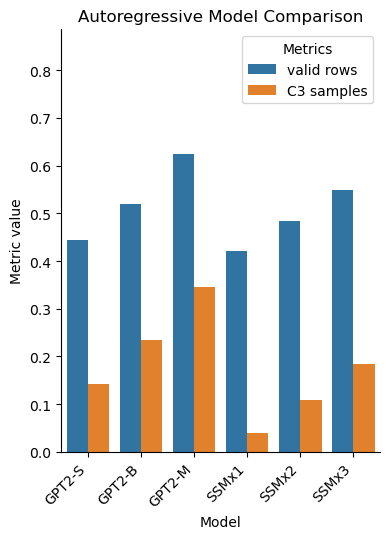

In [79]:
plot_data = finalplot_tab[['scale', 'Val/AnyValid_abinit', 'Val/C3_abinit', ]]#'''r2_ratio'
# remove the row with "EDMx2*" model
plot_data = plot_data[plot_data['scale'] != 'EDMx2*']
# rename column names valid -> valid row, C3 -> C3 sample
plot_data.columns = ['model', 'valid rows', 'C3 samples']
# Melting the data to long format suitable for sns.barplot
plot_data_melted = plot_data.melt(id_vars=['model'], var_name='Metric', value_name='Value')
# Creating the bar plot
plt.figure(figsize=(4, 5.5))
bar_plot = sns.barplot(x='model', y='Value', hue='Metric', data=plot_data_melted, 
                       order=["GPT2-S", "GPT2-B", "GPT2-M", "SSMx1", "SSMx2", "SSMx3"],)
                       #order=["GPT2CmbEmb_base", "GPT2_base", "GPT2_medium", "Mamba_base", "mamba_medium", "mamba_big"])
plt.title('Autoregressive Model Comparison')
plt.xlabel('Model')
plt.ylabel('Metric value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
# Show the plot
plt.tight_layout()
plt.ylim((0.0, 0.8858520528674125))
saveallforms(synopsisdir, 'autoreg_abinit_model_comparison_barplot_ylim_new')
plt.show()

In [80]:
synopsisdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_model_synopsis'

In [51]:
syndf_SSM.step

run_name
Mamba_base_uncond_heldout0      216099
mamba_big_uncond_all            246899
mamba_big_uncond_heldout0       216099
mamba_huge_uncond_all           239414
mamba_medium_uncond_all         246899
mamba_medium_uncond_heldout0    216099
Name: step, dtype: int64

In [54]:
syndf_GPT.query("step > 990000 and heldout==True")


UndefinedVariableError: name 'heldout' is not defined